<h1><center> Google QUEST - EDA and USE Baseline </center></h1>
<h2><center> Improving automated understanding of complex question answer content </center></h2>
<img src="https://storage.googleapis.com/kaggle-media/competitions/google-research/human_computable_dimensions_1.png" width="800">

#### From the competition overview:
>In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts. As such, each prompt was crafted in the most intuitive fashion so that raters could simply use their common-sense to complete the task. By lessening our dependency on complicated and opaque rating guidelines, we hope to increase the re-use value of this data set. What you see is what you get!

>Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.

##### Link for the dataset with the USE models: https://www.kaggle.com/dimitreoliveira/universalsentenceencodermodels

## Dependencies

In [17]:
import gc
import random
import warnings
import pandas as pd
# import tensorflow as tf
# import tensorflow_hub as hub
from nltk import FreqDist
from nltk.corpus import stopwords
#from ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
# from tensorflow.keras import Model, optimizers
# from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from googleqa_utilityscript import *

SEED = 0
#seed_everything(SEED)
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rcParams.update({'font.size': 16})

## Load data

In [18]:
train = pd.read_csv('C:/Users/Lab000/Desktop/kaggle/kaggle_competetion/Google_Quest_LABEL/my-solution/input/google-quest-challenge/train.csv')
test = pd.read_csv('C:/Users/Lab000/Desktop/kaggle/kaggle_competetion/Google_Quest_LABEL/my-solution/input/google-quest-challenge/test.csv')

train['set'] = 'train'
test['set'] = 'test'
complete_set = train.append(test)

print('Train samples: %s' % len(train))
print('Test samples: %s' % len(test))
display(train.head())

Train samples: 6079
Test samples: 476


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,train
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,train


# EDA
#### Each sample main features are the question and it's answer
#### First let's take a look at one pair of question/answer:

In [19]:
samp_id = 9
print('Question Title: %s \n' % train['question_title'].values[samp_id])
print('Question Body: %s \n' % train['question_body'].values[samp_id])
print('Answer: %s' % train['answer'].values[samp_id])

Question Title: How do you grapple in Dead Rising 3? 

Question Body: I just started playing Dead Rising 3 on the Xbox One. I got to the first grapple, and I can't figure out what I'm supposed to do. The top of the screen says "Perform a gesture to escape a grapple" - what does "gesture" mean in this context? Is it something to do with Kinect?
 

Answer: You can also switch gesture based grapple escapes off in the Kinect settings of Dead Rising 3 (along with all the rest of the Kinect features) so that you have to do QTE type button presses instead.



#### Each question/answer are given some ratings, those ratings are the competition labels, let's see this sample labels

In [20]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

print('Question labels')
display(train.iloc[[samp_id]][question_target_cols])
print('Answer labels')
display(train.iloc[[samp_id]][answer_target_cols])

Question labels


,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
9,1.0,0.777778,0.0,0.333333,1.0,1.0,0.777778,0.888889,0.666667,0.0,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.0,1.0


Answer labels


,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
9,0.777778,0.333333,0.777778,0.777778,0.533333,0.333333,0.0,0.666667,0.777778


#### How are distributed between sets users that ask questions?

In [21]:
train_users = set(train['question_user_page'].unique())
test_users = set(test['question_user_page'].unique())

print('Unique users in train set: %s' % len(train_users))
print('Unique users in test set: %s' % len(test_users))
print('Users in both sets: %s' % len(train_users & test_users))
print('What users are in both sets? %s' % list(train_users & test_users))

Unique users in train set: 3422
Unique users in test set: 474
Users in both sets: 1
What users are in both sets? ['https://salesforce.stackexchange.com/users/686']


#### How are distributed between sets users that answer questions?

In [22]:
train_users = set(train['answer_user_page'].unique())
test_users = set(test['answer_user_page'].unique())

print('Unique users in train set: %s' % len(train_users))
print('Unique users in test set: %s' % len(test_users))
print('Users in both sets: %s' % len(train_users & test_users))

Unique users in train set: 4430
Unique users in test set: 367
Users in both sets: 0


### Could be interesting to see the ranks of users that ask and answer more questions
#### Question user ranking

,question_user_name,question_user_page,count
2187,Shane,https://stats.stackexchange.com/users/5,12
2056,Rory,https://programmers.stackexchange.com/users/48536,11
1378,Louis Rhys,https://programmers.stackexchange.com/users/8486,11
198,András,https://rpg.stackexchange.com/users/9552,11
568,DVK-on-Ahch-To,https://scifi.stackexchange.com/users/976,10


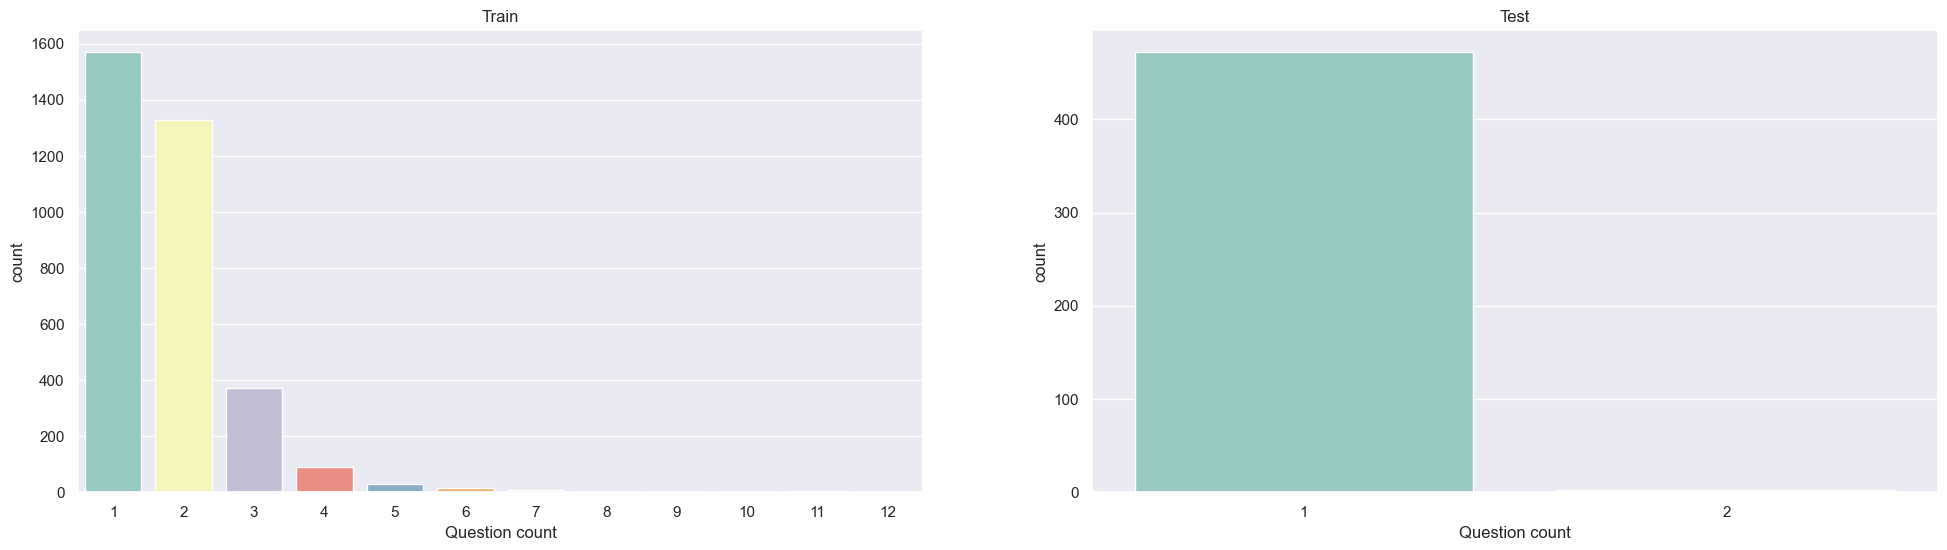

In [23]:
question_gp = complete_set[['qa_id', 'question_user_name', 'question_user_page']].groupby(['question_user_name', 'question_user_page'], as_index=False).count()
question_gp.columns = ['question_user_name', 'question_user_page', 'count']
display(question_gp.sort_values('count', ascending=False).head())

train_question_gp = train[['qa_id', 'question_user_page']].groupby('question_user_page', as_index=False).count()
test_question_gp = test[['qa_id', 'question_user_page']].groupby('question_user_page', as_index=False).count()
train_question_gp.columns = ['question_user_page', 'Question count']
test_question_gp.columns = ['question_user_page', 'Question count']

sns.set(style="darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.countplot(x="Question count", data=train_question_gp, palette="Set3", ax=ax1).set_title("Train")
sns.countplot(x="Question count", data=test_question_gp, palette="Set3", ax=ax2).set_title("Test")
plt.show()

#### Answer user ranking

,answer_user_name,answer_user_page,count
3770,egreg,https://tex.stackexchange.com/users/4427,17
2820,Scott,https://graphicdesign.stackexchange.com/users/...,16
1954,Marius,https://magento.stackexchange.com/users/146,15
264,Andy aka,https://electronics.stackexchange.com/users/20218,14
2532,Pᴀᴜʟsᴛᴇʀ2,https://mechanics.stackexchange.com/users/4152,11


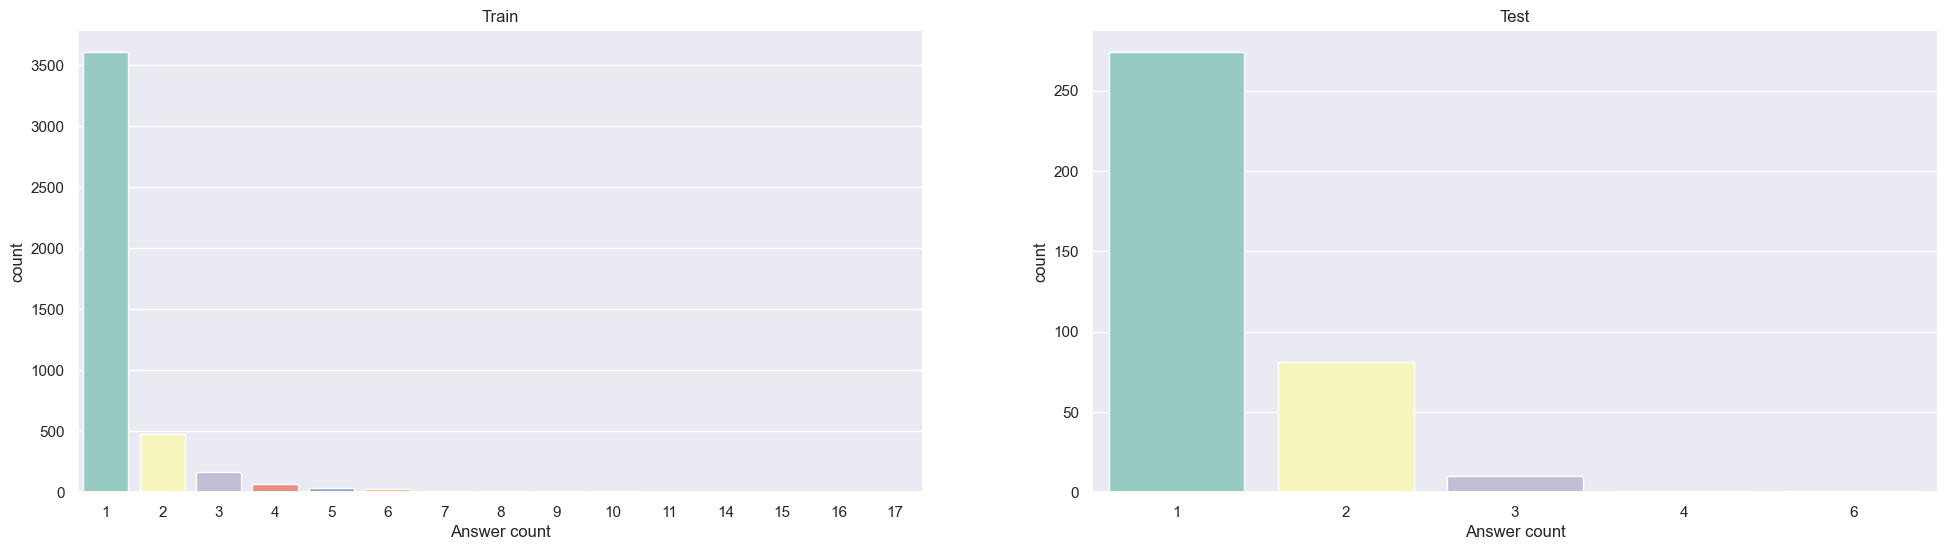

In [24]:
answer_gp = complete_set[['qa_id', 'answer_user_name', 'answer_user_page']].groupby(['answer_user_name', 'answer_user_page'], as_index=False).count()
answer_gp.columns = ['answer_user_name', 'answer_user_page', 'count']
display(answer_gp.sort_values('count', ascending=False).head())

train_answer_gp = train[['qa_id', 'answer_user_page']].groupby('answer_user_page', as_index=False).count()
test_answer_gp = test[['qa_id', 'answer_user_page']].groupby('answer_user_page', as_index=False).count()
train_answer_gp.columns = ['answer_user_page', 'Answer count']
test_answer_gp.columns = ['answer_user_page', 'Answer count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.countplot(x="Answer count", data=train_answer_gp, palette="Set3", ax=ax1).set_title("Train")
sns.countplot(x="Answer count", data=test_answer_gp, palette="Set3", ax=ax2).set_title("Test")
plt.show()

## Let's do the same for the question titles

,question_title,count
3298,What is the best introductory Bayesian statist...,12
1837,Important non-technical course for programmers?,11
3225,What does mathematics have to do with programm...,11
1671,"How to prevent the ""Too awesome to use"" syndrome",9
2374,No sound in Ubuntu except at log in,7


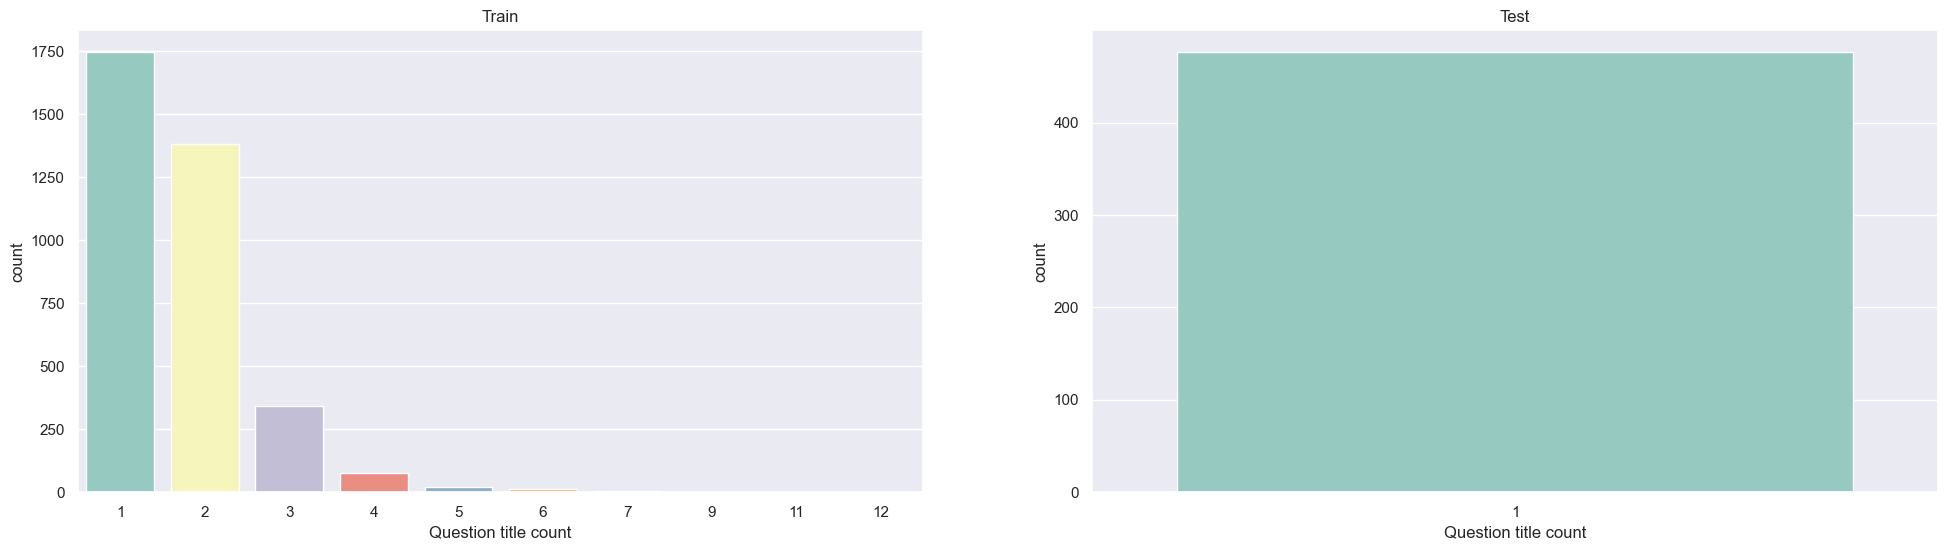

In [25]:
question_title_gp = complete_set[['qa_id', 'question_title']].groupby('question_title', as_index=False).count()
question_title_gp.columns = ['question_title', 'count']
display(question_title_gp.sort_values('count', ascending=False).head())

train_question_title_gp = train[['qa_id', 'question_title']].groupby('question_title', as_index=False).count()
test_question_title_gp = test[['qa_id', 'question_title']].groupby('question_title', as_index=False).count()
train_question_title_gp.columns = ['question_title', 'Question title count']
test_question_title_gp.columns = ['question_title', 'Question title count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.countplot(x="Question title count", data=train_question_title_gp, palette="Set3", ax=ax1).set_title("Train")
sns.countplot(x="Question title count", data=test_question_title_gp, palette="Set3", ax=ax2).set_title("Test")
plt.show()

## Now for the question bodies

,question_body,count
3897,Which is the best introductory textbook for Ba...,12
3800,What kind of non-technical training course do ...,11
1720,I just started a diploma in software developme...,11
3885,When you give the player a rare but powerful i...,9
666,I am a graduate student in math in my final ye...,7


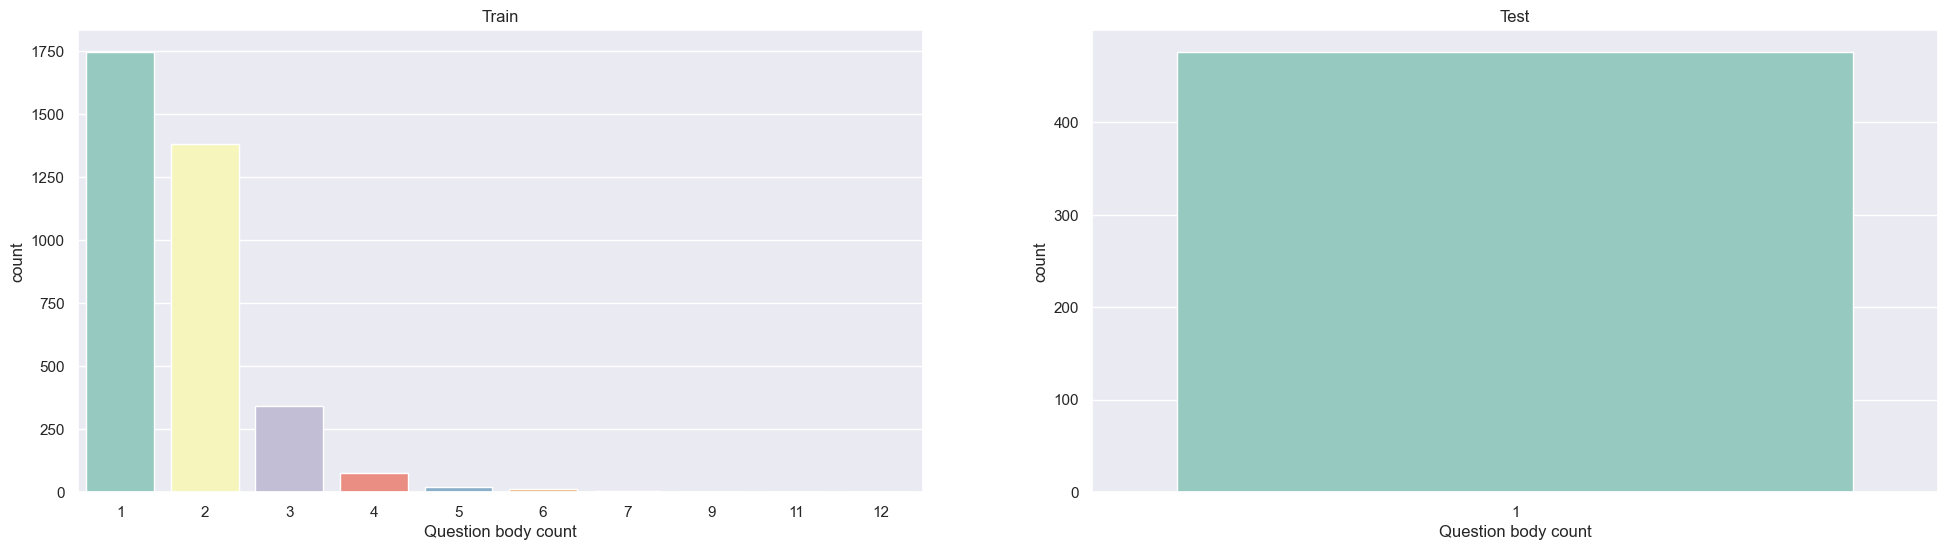

In [26]:
question_body_gp = complete_set[['qa_id', 'question_body']].groupby('question_body', as_index=False).count()
question_body_gp.columns = ['question_body', 'count']
display(question_body_gp.sort_values('count', ascending=False).head())

train_question_body_gp = train[['qa_id', 'question_body']].groupby('question_body', as_index=False).count()
test_question_body_gp = test[['qa_id', 'question_body']].groupby('question_body', as_index=False).count()
train_question_body_gp.columns = ['question_body', 'Question body count']
test_question_body_gp.columns = ['question_body', 'Question body count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.countplot(x="Question body count", data=train_question_body_gp, palette="Set3", ax=ax1).set_title("Train")
sns.countplot(x="Question body count", data=test_question_body_gp, palette="Set3", ax=ax2).set_title("Test")
plt.show()

#### For the answers there are no duplicates

## Now we will take a look at some statistics of the text data

### Question title length and word count

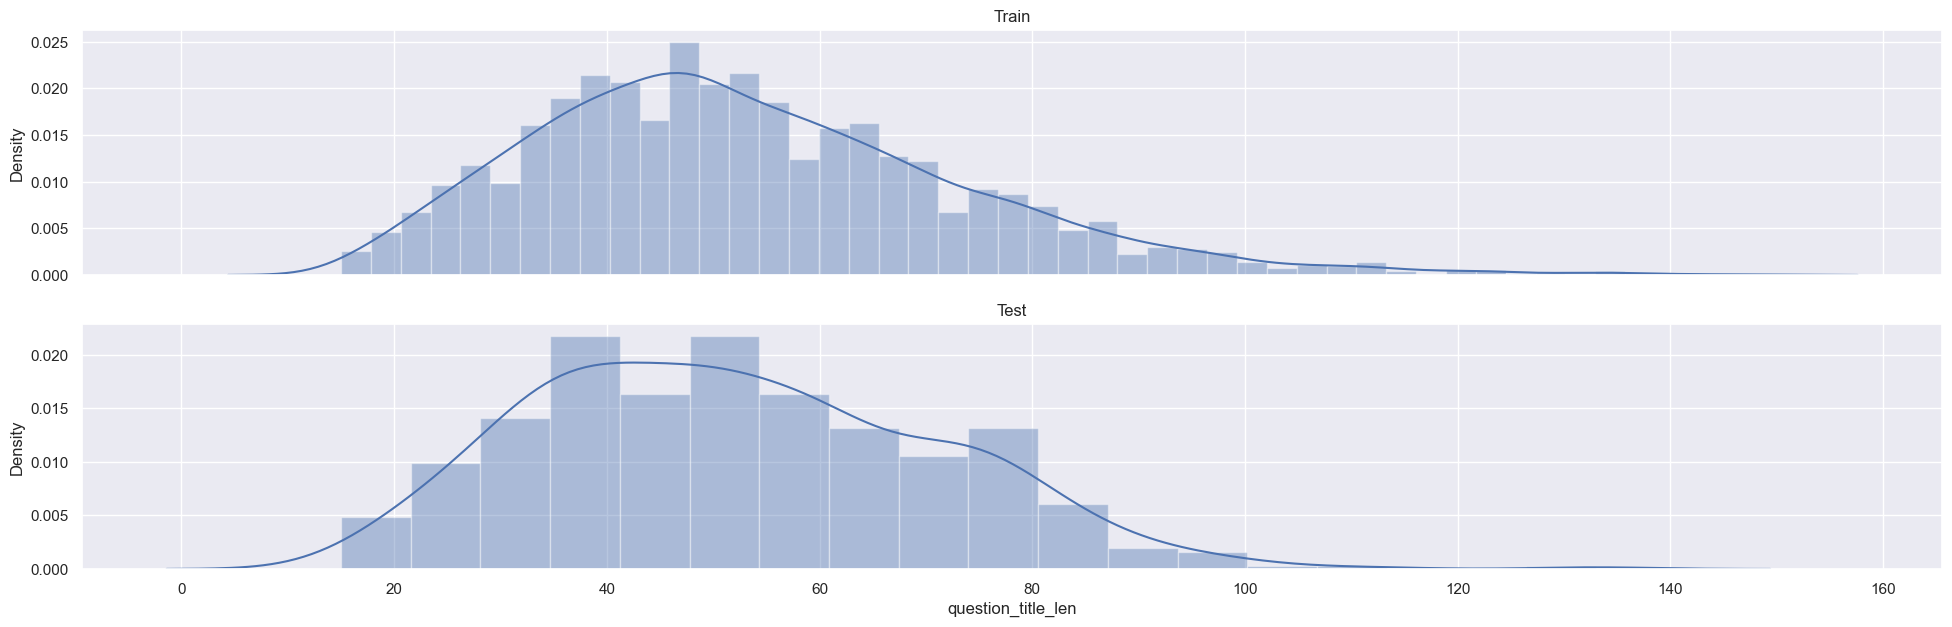

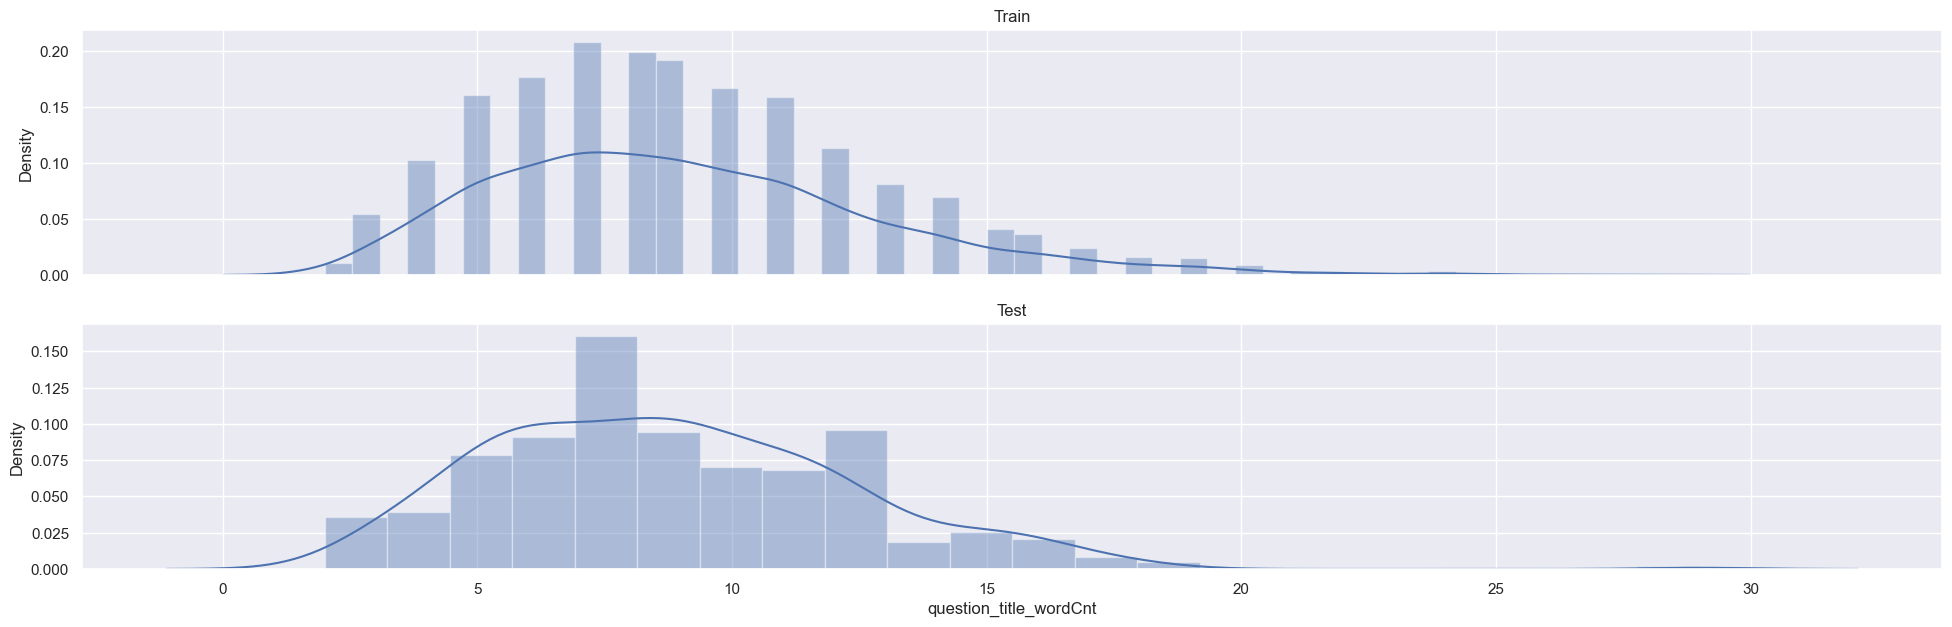

In [27]:
complete_set['question_title_len'] = complete_set['question_title'].apply(lambda x : len(x))
complete_set['question_body_len'] = complete_set['question_body'].apply(lambda x : len(x))
complete_set['answer_len'] = complete_set['answer'].apply(lambda x : len(x))
complete_set['question_title_wordCnt'] = complete_set['question_title'].apply(lambda x : len(x.split(' ')))
complete_set['question_body_wordCnt'] = complete_set['question_body'].apply(lambda x : len(x.split(' ')))
complete_set['answer_wordCnt'] = complete_set['answer'].apply(lambda x : len(x.split(' ')))

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['question_title_len'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['question_title_len'], ax=ax2).set_title("Test")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['question_title_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['question_title_wordCnt'], ax=ax2).set_title("Test")
plt.show()

### Question body length and word count

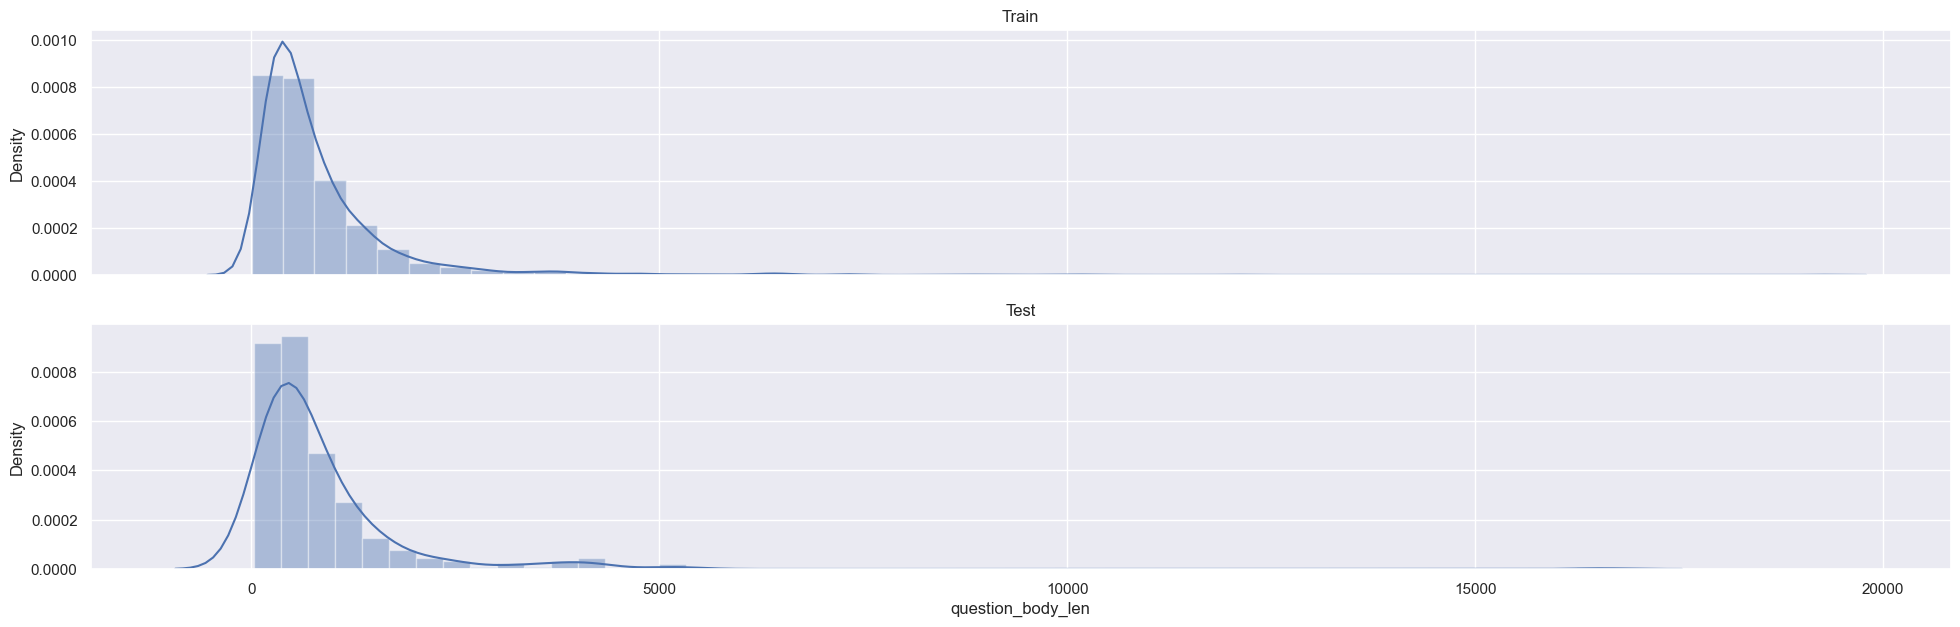

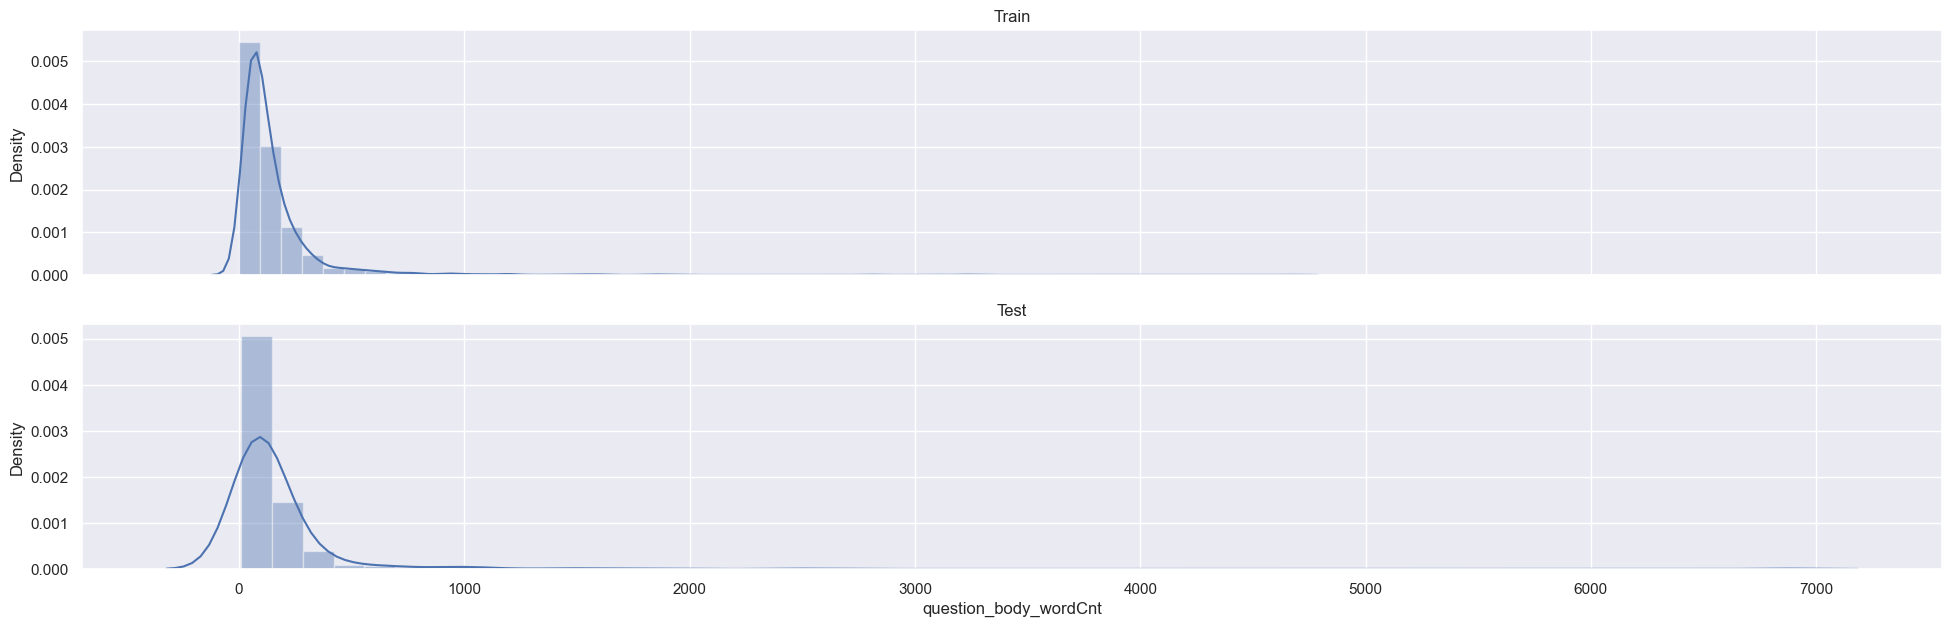

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['question_body_len'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['question_body_len'], ax=ax2).set_title("Test")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['question_body_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['question_body_wordCnt'], ax=ax2).set_title("Test")
plt.show()

### Answer length and word count

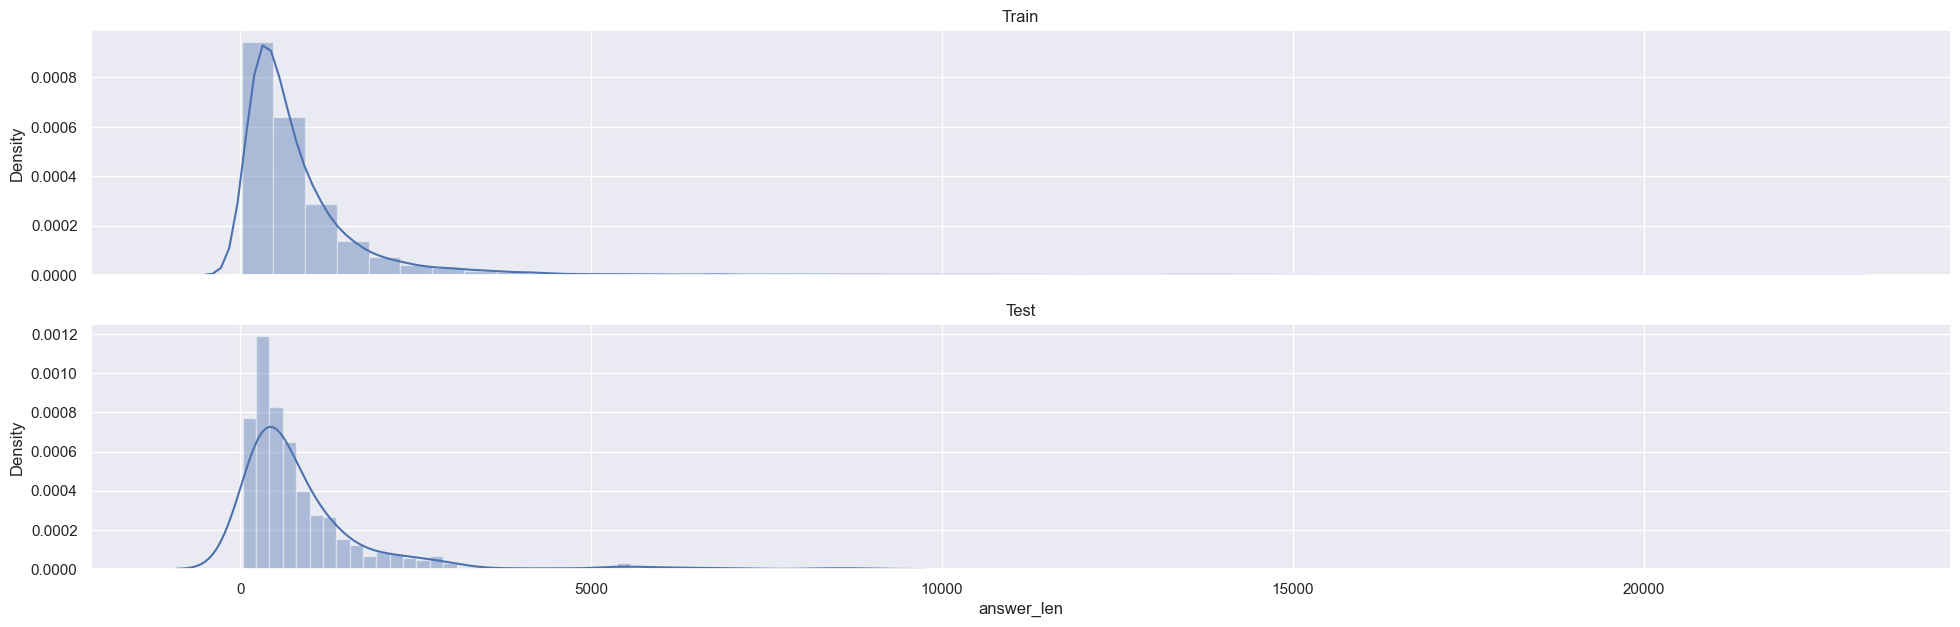

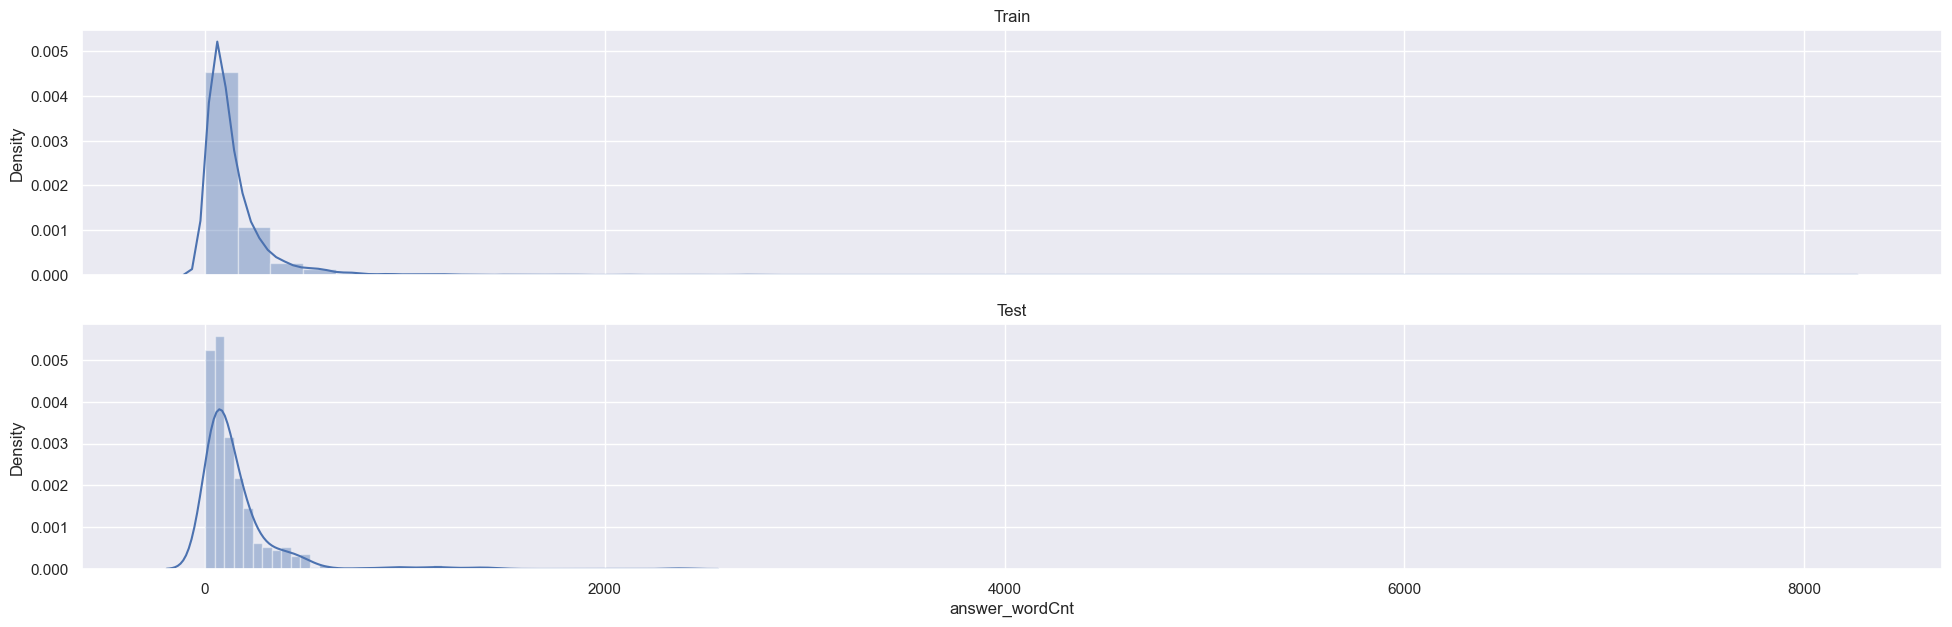

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['answer_len'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['answer_len'], ax=ax2).set_title("Test")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 7), sharex=True)
sns.distplot(complete_set[complete_set['set'] == 'train']['answer_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(complete_set[complete_set['set'] == 'test']['answer_wordCnt'], ax=ax2).set_title("Test")
plt.show()

### We also have a "category" column that is related to the question/answer
- It seems that at least the "Technology" and "SCIENCE" categories have a very diferent distribution among sets

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7), sharex=True)
sns.countplot(complete_set[complete_set['set'] == 'train']['category'], ax=ax1).set_title("Train")
sns.countplot(complete_set[complete_set['set'] == 'test']['category'], ax=ax2).set_title("Test")
plt.show()

### The "host" column is related to where the questions and answers where published

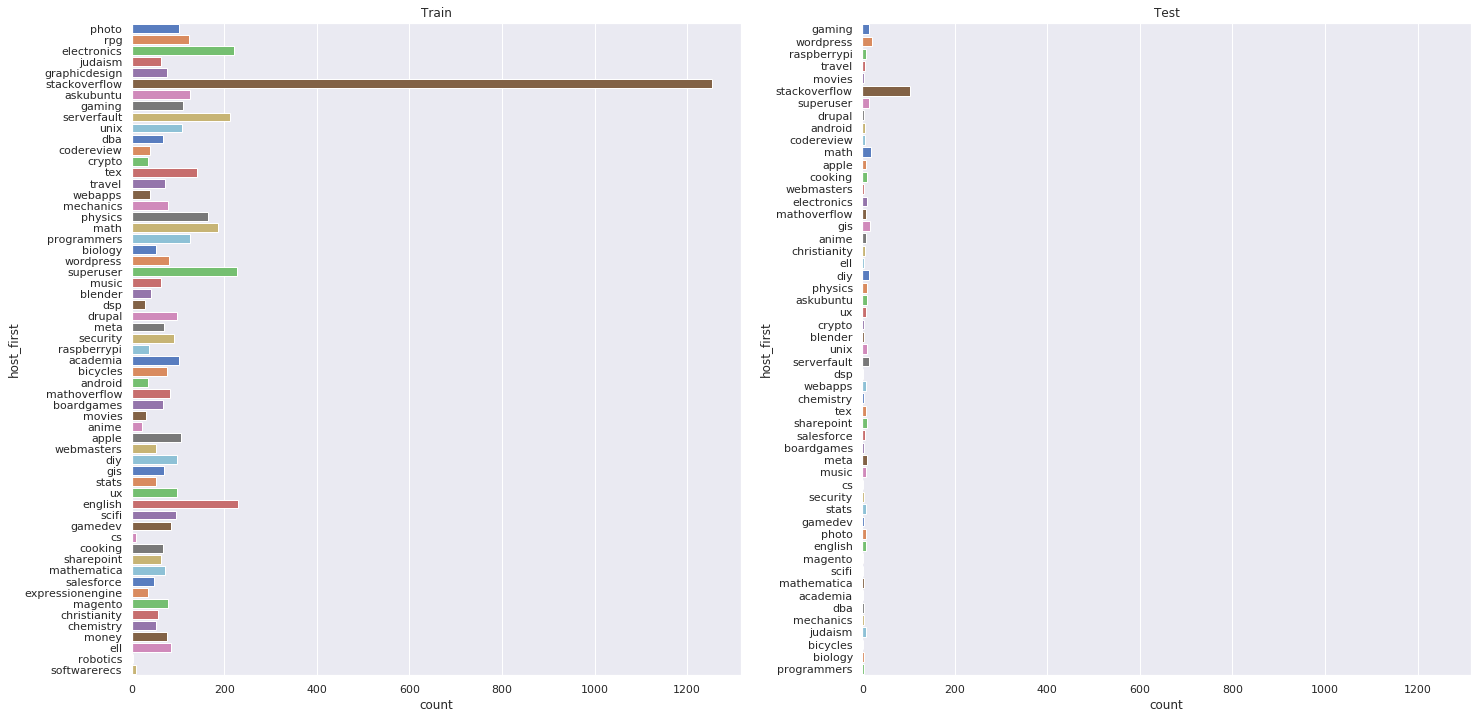

In [ ]:
complete_set['host_first'] = complete_set['host'].apply(lambda x : x.split('.')[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12), sharex=True)
sns.countplot(y=complete_set[complete_set['set'] == 'train']['host_first'], ax=ax1, palette="muted").set_title("Train")
sns.countplot(y=complete_set[complete_set['set'] == 'test']['host_first'], ax=ax2, palette="muted").set_title("Test")
plt.show()

## Lastly let's look at the labels distribution
### Question related labels

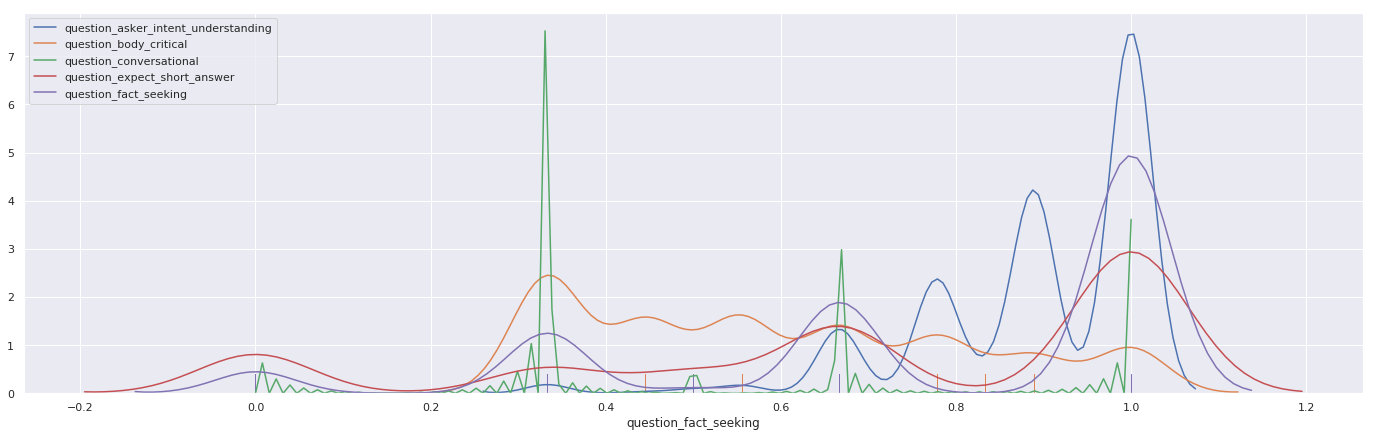

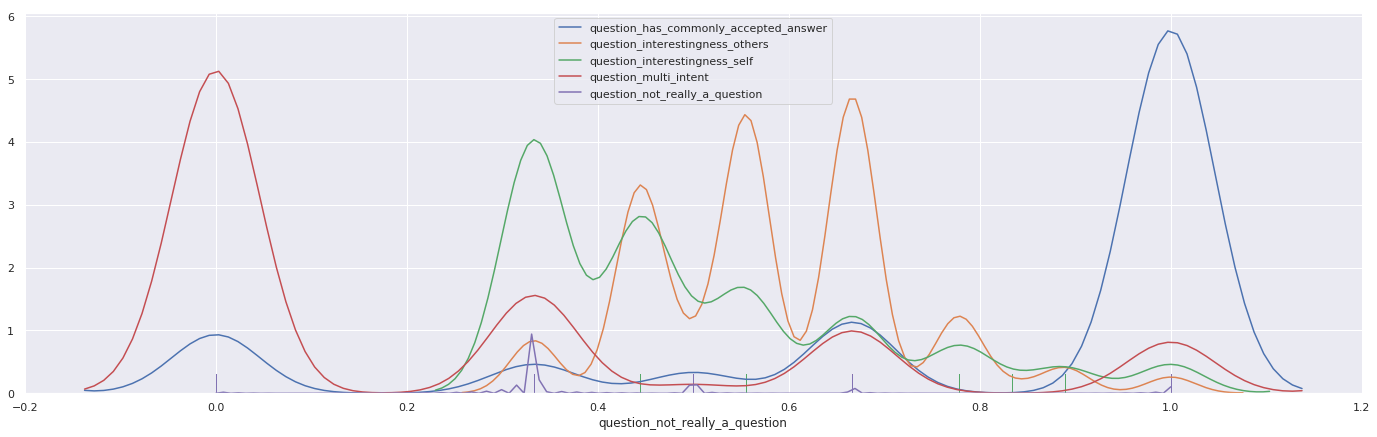

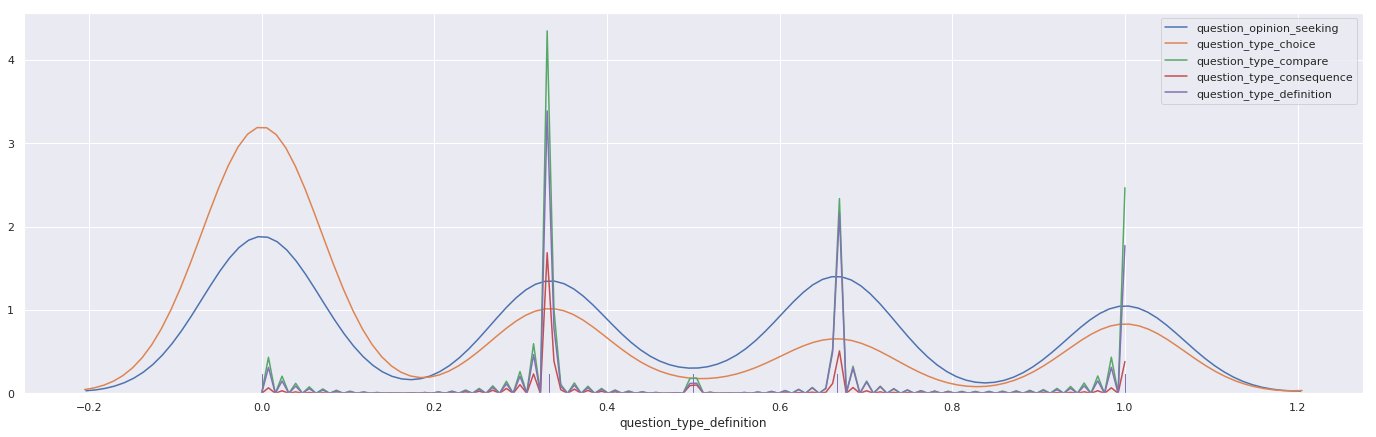

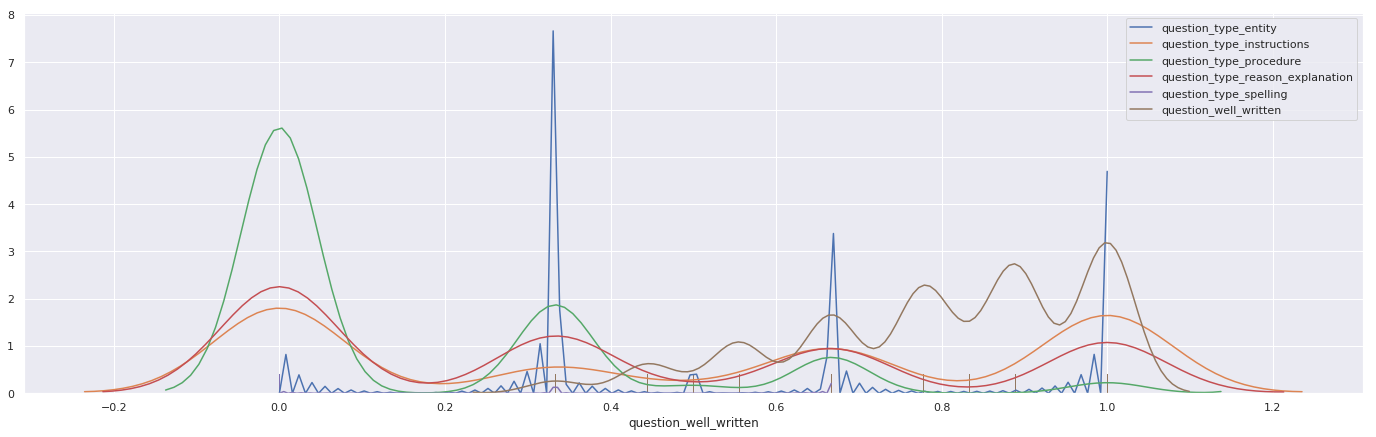

In [ ]:
f = plt.subplots(figsize=(24, 7))
for col in question_target_cols[:5]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

f = plt.subplots(figsize=(24, 7))
for col in question_target_cols[5:10]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

f = plt.subplots(figsize=(24, 7))
for col in question_target_cols[10:15]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

f = plt.subplots(figsize=(24, 7))
for col in question_target_cols[15:]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

### Answer related labels

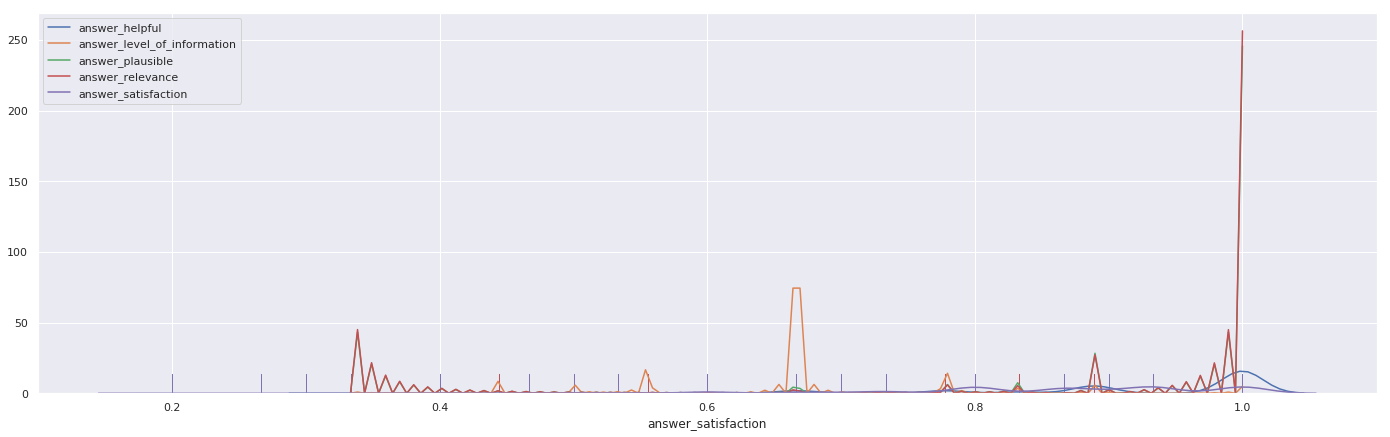

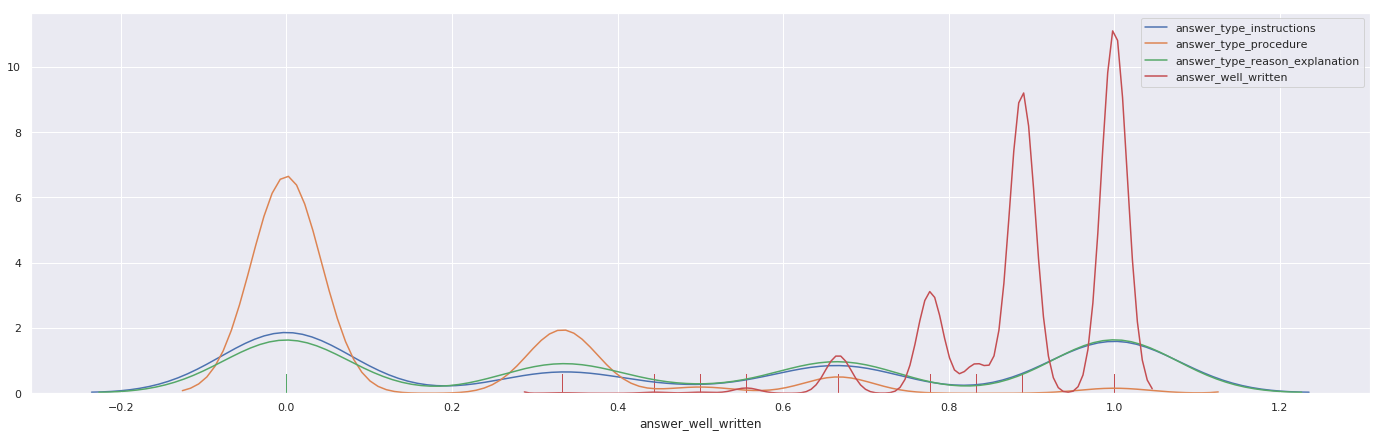

In [ ]:
f = plt.subplots(figsize=(24, 7))
for col in answer_target_cols[:5]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

f = plt.subplots(figsize=(24, 7))
for col in answer_target_cols[5:]:
    sns.distplot(train[col], label=col, rug=True, hist=False)
plt.show()

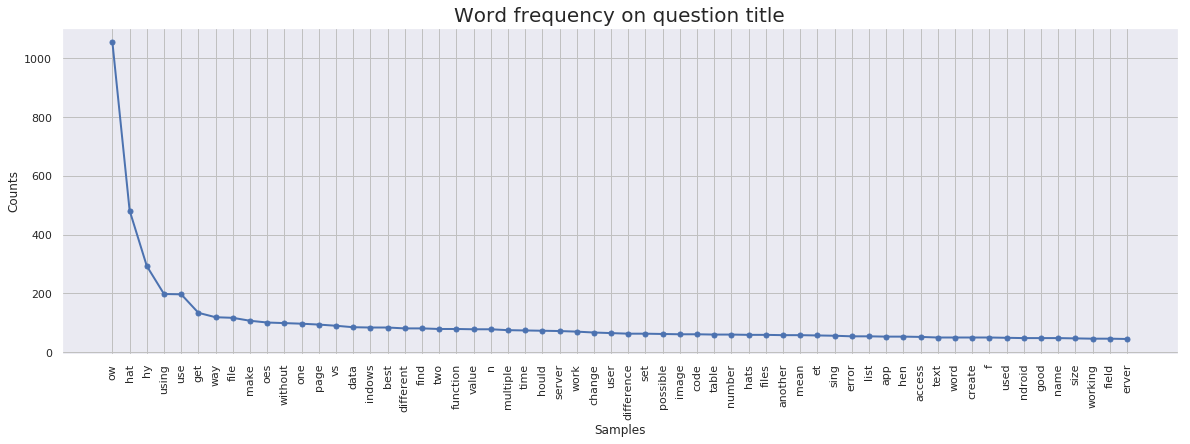

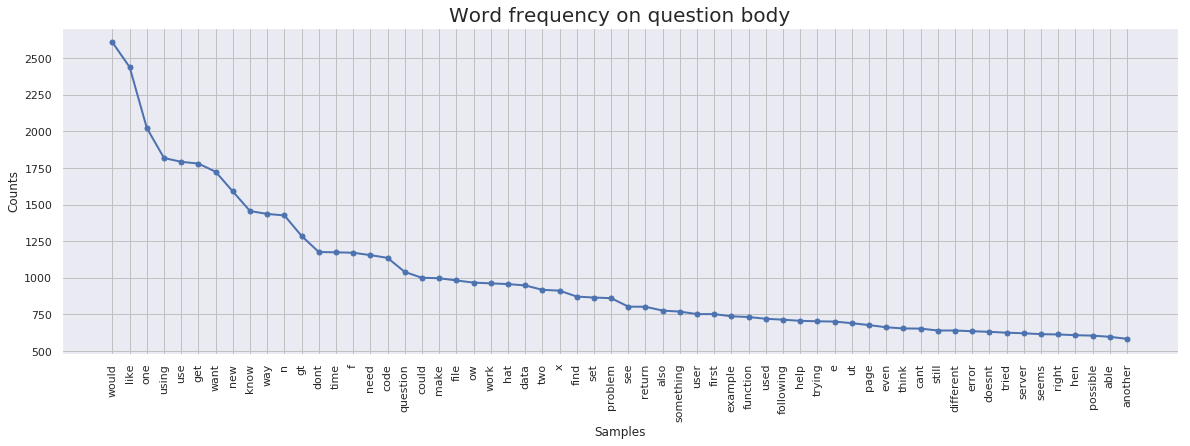

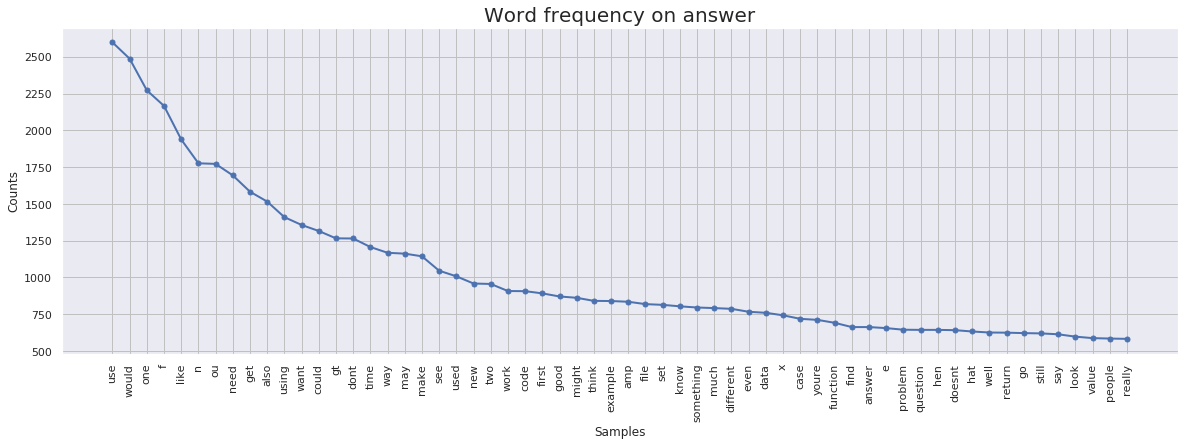

In [ ]:
eng_stopwords = stopwords.words('english')

complete_set['question_title'] = complete_set['question_title'].str.replace('[^a-z ]','')
complete_set['question_body'] = complete_set['question_body'].str.replace('[^a-z ]','')
complete_set['answer'] = complete_set['answer'].str.replace('[^a-z ]','')
complete_set['question_title'] = complete_set['question_title'].apply(lambda x: x.lower())
complete_set['question_body'] = complete_set['question_body'].apply(lambda x: x.lower())
complete_set['answer'] = complete_set['answer'].apply(lambda x: x.lower())

freq_dist = FreqDist([word for comment in complete_set['question_title'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on question title').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

freq_dist = FreqDist([word for comment in complete_set['question_body'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on question body').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

freq_dist = FreqDist([word for comment in complete_set['answer'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on answer').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

In [ ]:
gc.collect()

16472

# Model parameters

In [ ]:
EPOCHS = 12
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 3
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
module_url = "../input/universalsentenceencodermodels/universal-sentence-encoder-models/use-qa"

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

# Model
## For the model we will use Universal Sentence Encoder (USE for short)
#### From the [Tensorflow hub page](https://tfhub.dev/google/universal-sentence-encoder/4):
>The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

>The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder-large model is trained with a Transformer encoder.

##### Link for the dataset with the USE models: https://www.kaggle.com/dimitreoliveira/universalsentenceencodermodels

In [ ]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def model_fn():
    input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
    embedding_title = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_title)

    input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
    embedding_body = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_body)

    input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
    embedding_answer = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_answer)

    x = Concatenate()([embedding_title, embedding_body, embedding_answer])
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(N_CLASS, activation='sigmoid', name='output')(x)
    model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

    optimizer = optimizers.Adam(LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    return model

# Train model (3-Fold)
- I got the CV split and the evaluation from @ratthachat [awsome kernel](https://www.kaggle.com/ratthachat/quest-cv-analysis-on-different-splitting-methods), there is an explanation about why use this CV scheme checkout. 

In [ ]:
feature_cols = ['question_title', 'question_body', 'answer']
Y_train = train[target_cols]

NUM_FOLDS = 3
train_rho_kfolds = []
valid_rho_kfolds = []
model_path_list = []
kf = MultilabelStratifiedKFold(n_splits=NUM_FOLDS, random_state=SEED)

for ind, (tr, val) in enumerate(kf.split(train[feature_cols], Y_train)):
    print('FOLD', ind+1)
    X_tr = train[feature_cols].loc[tr]
    y_tr = Y_train.loc[tr].values
    X_vl = train[feature_cols].loc[val]
    y_vl = Y_train.loc[val].values

    X_tr = [X_tr[col] for col in feature_cols]
    X_vl = [X_vl[col] for col in feature_cols]
    
    
    model = model_fn()
    spearmanCallback = SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl))
    callback_list = [es, rlrop, spearmanCallback]
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_vl, y_vl), 
                        batch_size=BATCH_SIZE, 
                        callbacks=callback_list, 
                        epochs=EPOCHS, 
                        verbose=2).history
    
    preds_train = model.predict(X_tr)
    preds_val = model.predict(X_vl)

    rho_train = [spearmanr(y_tr[:, ind], preds_train[:, ind] + np.random.normal(0, 1e-7, preds_train.shape[0])).correlation for ind in range(preds_train.shape[1])]
    rho_val = [spearmanr(y_vl[:, ind], preds_val[:, ind] + np.random.normal(0, 1e-7, preds_val.shape[0])).correlation for ind in range(preds_val.shape[1])]

    train_rho_kfolds.append(rho_train)
    valid_rho_kfolds.append(rho_val)
    print('Train spearman-rho: %.3f' % np.mean(rho_train))
    print('Validation spearman-rho: %.3f' % np.mean(rho_val))
    
    model_path = '../working/use_baseline_fold_%d.h5' % (ind+1)
    model.save_weights(model_path)
    model_path_list.append(model_path)
    print('Saved model at: %s' % model_path)

FOLD 1
Train on 4051 samples, validate on 2028 samples
Epoch 1/12
Train spearman-rho: 0.2108 Validation spearman-rho: 0.1969
4051/4051 - 222s - loss: 0.5094 - val_loss: 0.4150
Epoch 2/12
Train spearman-rho: 0.2959 Validation spearman-rho: 0.2761
4051/4051 - 124s - loss: 0.4098 - val_loss: 0.3964
Epoch 3/12
Train spearman-rho: 0.3404 Validation spearman-rho: 0.3135
4051/4051 - 123s - loss: 0.3974 - val_loss: 0.3880
Epoch 4/12
Train spearman-rho: 0.3674 Validation spearman-rho: 0.3341
4051/4051 - 122s - loss: 0.3905 - val_loss: 0.3832
Epoch 5/12
Train spearman-rho: 0.3843 Validation spearman-rho: 0.3448
4051/4051 - 122s - loss: 0.3857 - val_loss: 0.3805
Epoch 6/12
Train spearman-rho: 0.3976 Validation spearman-rho: 0.3529
4051/4051 - 122s - loss: 0.3823 - val_loss: 0.3779
Epoch 7/12
Train spearman-rho: 0.4090 Validation spearman-rho: 0.3593
4051/4051 - 123s - loss: 0.3798 - val_loss: 0.3764
Epoch 8/12
Train spearman-rho: 0.4176 Validation spearman-rho: 0.3626
4051/4051 - 122s - loss: 0.3

## Model loss graph (the last one) 

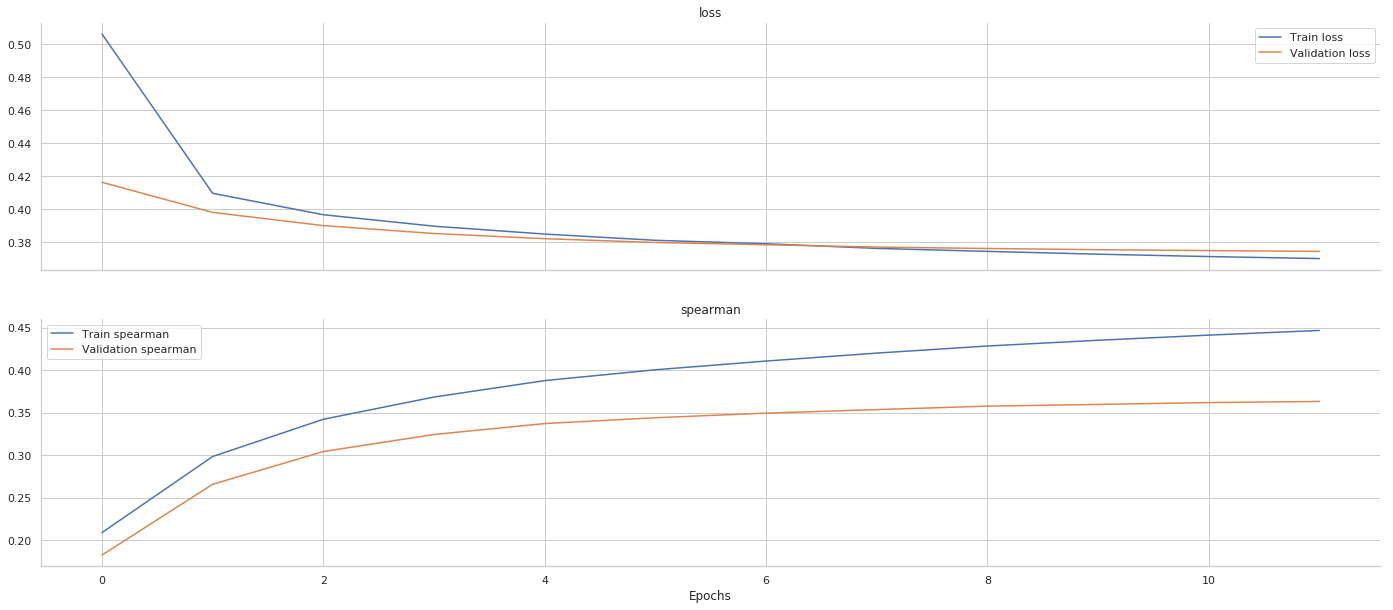

In [ ]:
sns.set(style="whitegrid")
for key in spearmanCallback.history.keys():
    history[key] = spearmanCallback.history[key]

plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [ ]:
print('Train')
print('Averaged spearman-rho: %.3f' % np.mean(train_rho_kfolds))
print('Averaged spearman-rho (nanmean): %.3f' % np.nanmean(train_rho_kfolds))
print('Averaged spearman-rho avg(regular and nanmean): %.3f +/- %.3f'% (np.mean(train_rho_kfolds), np.std(np.mean(train_rho_kfolds))))
print('\nValidation')
print('Averaged spearman-rho: %.3f' % np.mean(valid_rho_kfolds))
print('Averaged spearman-rho (nanmean): %.3f' % np.nanmean(valid_rho_kfolds))
print('Averaged spearman-rho avg(regular and nanmean): %.3f +/- %.3f'% (np.mean(valid_rho_kfolds), np.std(np.mean(valid_rho_kfolds))))

print('\nEach label :')
spearman_avg_per_label = np.mean(valid_rho_kfolds, axis=0)
spearman_std_per_label = np.std(valid_rho_kfolds, axis=0)
for ii in range(len(target_cols)):
    print('%d - %.3f +/- %.3f - %s' % (ii+1,spearman_avg_per_label[ii],spearman_std_per_label[ii],
                                       target_cols[ii] ))

Train
Averaged spearman-rho: 0.446
Averaged spearman-rho (nanmean): 0.446
Averaged spearman-rho avg(regular and nanmean): 0.446 +/- 0.000

Validation
Averaged spearman-rho: 0.369
Averaged spearman-rho (nanmean): 0.369
Averaged spearman-rho avg(regular and nanmean): 0.369 +/- 0.000

Each label :
1 - 0.365 +/- 0.019 - question_asker_intent_understanding
2 - 0.632 +/- 0.002 - question_body_critical
3 - 0.409 +/- 0.008 - question_conversational
4 - 0.255 +/- 0.019 - question_expect_short_answer
5 - 0.326 +/- 0.004 - question_fact_seeking
6 - 0.431 +/- 0.008 - question_has_commonly_accepted_answer
7 - 0.358 +/- 0.020 - question_interestingness_others
8 - 0.497 +/- 0.010 - question_interestingness_self
9 - 0.386 +/- 0.007 - question_multi_intent
10 - 0.024 +/- 0.026 - question_not_really_a_question
11 - 0.440 +/- 0.009 - question_opinion_seeking
12 - 0.612 +/- 0.007 - question_type_choice
13 - 0.332 +/- 0.012 - question_type_compare
14 - 0.148 +/- 0.003 - question_type_consequence
15 - 0.347

# Make predictions on test

In [ ]:
# Test features
X_test_title = test['question_title']
X_test_body = test['question_body']
X_test_answer = test['answer']

X_test = [X_test_title, X_test_body, X_test_answer]
Y_test = np.zeros((len(test), len(target_cols)))

for model_path in model_path_list:
    model = model_fn()
    model.load_weights(model_path)
    Y_test += model.predict(X_test) / NUM_FOLDS

In [ ]:
submission = pd.read_csv('/kaggle/input/google-quest-challenge/sample_submission.csv')
submission[target_cols] = Y_test
submission.to_csv("submission.csv", index=False)
display(submission.head())

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.929177,0.642249,0.181961,0.711786,0.571048,0.639082,0.640266,0.585222,0.282547,...,0.894834,0.916303,0.618119,0.963270,0.971739,0.825615,0.103993,0.066820,0.692907,0.931238
1,46,0.876323,0.563958,0.004765,0.691602,0.824859,0.913822,0.574886,0.462792,0.144953,...,0.735490,0.932362,0.630497,0.962854,0.971554,0.853942,0.911399,0.162685,0.143677,0.887382
2,70,0.901261,0.625119,0.021019,0.709625,0.878576,0.905168,0.604978,0.493166,0.369128,...,0.850752,0.924478,0.627302,0.964087,0.968991,0.834721,0.173896,0.094084,0.815110,0.905080
3,132,0.874537,0.454596,0.019114,0.713421,0.793909,0.877591,0.568093,0.496930,0.266367,...,0.720073,0.933101,0.700823,0.962180,0.976767,0.891116,0.638774,0.129397,0.697504,0.893267
4,200,0.933471,0.567799,0.014884,0.841437,0.819459,0.909874,0.624493,0.559456,0.271535,...,0.808117,0.944793,0.668823,0.975169,0.977868,0.869973,0.476377,0.160210,0.510193,0.923233
